### Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage
import seaborn as sns

### Função para calcular métricas de avaliação

In [5]:
# Função para calcular métricas de avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return mae, rmse, mape, smape, r2, wmape

### Carregar Dados Históricos do Preço do Petróleo Brent

In [6]:
# Carregar os dados
caminho_do_arquivo = 'preco_petroleo_brent.xlsx'
Dados_Historicos_Preco_Petroleo = pd.read_excel(caminho_do_arquivo)
Dados_Historicos_Preco_Petroleo['Data'] = pd.to_datetime(Dados_Historicos_Preco_Petroleo['Data'], format='%d.%m.%Y')
Dados_Historicos_Preco_Petroleo.set_index('Data', inplace=True)
Dados_Historicos_Preco_Petroleo = Dados_Historicos_Preco_Petroleo.sort_values(ascending=True, by='Data')

# Resetar índice
df_Preco_Petroleo = Dados_Historicos_Preco_Petroleo.reset_index(drop=False)
df_Preco_Petroleo = df_Preco_Petroleo.rename(columns={'Data': 'ds', 'Preço - petróleo bruto - Brent (FOB)': 'y'})

display(df_Preco_Petroleo.head())
display(df_Preco_Petroleo.tail())

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


,ds,y
11273,2024-10-09,77.06
11274,2024-10-10,79.45
11275,2024-10-11,80.27
11276,2024-10-12,78.47
11277,2024-10-15,73.68


In [7]:
def filter_dataframe_by_date(df, start_date, end_date=None):
    if end_date is None:
        end_date = df['ds'].max().strftime('%Y-%m-%d')
    mask = (df['ds'] >= start_date) & (df['ds'] <= end_date)
    return df.loc[mask]

# Exemplos de uso da função
start_date = '2021-09-01'

# Passando end_date como None para usar a última data disponível no dataframe
df_Preco_Petroleo = filter_dataframe_by_date(df_Preco_Petroleo, start_date, end_date=None)

# Calcular o número de dias selecionado
num_days_selected = len(df_Preco_Petroleo)
print(f'Número de dias selecionados: {num_days_selected}')

# # Exibir o dataframe filtrado
display(df_Preco_Petroleo.tail())

Número de dias selecionados: 795


,ds,y
11273,2024-10-09,77.06
11274,2024-10-10,79.45
11275,2024-10-11,80.27
11276,2024-10-12,78.47
11277,2024-10-15,73.68


### 1.1 Dividir Dados em Treino e Teste

In [8]:
# Dividir dados em treino e teste
train = df_Preco_Petroleo[df_Preco_Petroleo['ds'] < '2024-09-01']
test = df_Preco_Petroleo[df_Preco_Petroleo['ds'] >= '2024-09-01']

# Verificar a divisão
print(f'Tamanho do conjunto de treino: {len(train)}')
print(f'Tamanho do conjunto de teste: {len(test)}')

# Exibir as primeiras linhas dos conjuntos de treino e teste
display(train.head(), test.head())

Tamanho do conjunto de treino: 763
Tamanho do conjunto de teste: 32


,ds,y
10483,2021-09-01,71.99
10484,2021-09-02,73.56
10485,2021-09-03,73.07
10486,2021-09-06,72.43
10487,2021-09-07,71.52


,ds,y
11246,2024-09-02,77.82
11247,2024-09-03,76.46
11248,2024-09-04,74.67
11249,2024-09-05,74.47
11250,2024-09-06,72.82


### 1.2 Treinar o Modelo Prophet para Previsões do Período de TESTE

In [9]:
# Treinar o modelo Prophet com feriados
model = Prophet()
model.fit(train)

# Fazer previsões futuras para o período de teste
future_teste = model.make_future_dataframe(periods=len(test), freq='B')  # 'B' para dias úteis
forecast = model.predict(future_teste)

23:34:51 - cmdstanpy - INFO - Chain [1] start processing
23:34:51 - cmdstanpy - INFO - Chain [1] done processing


### 1.3 Plotar as Previsões para o Período de Teste

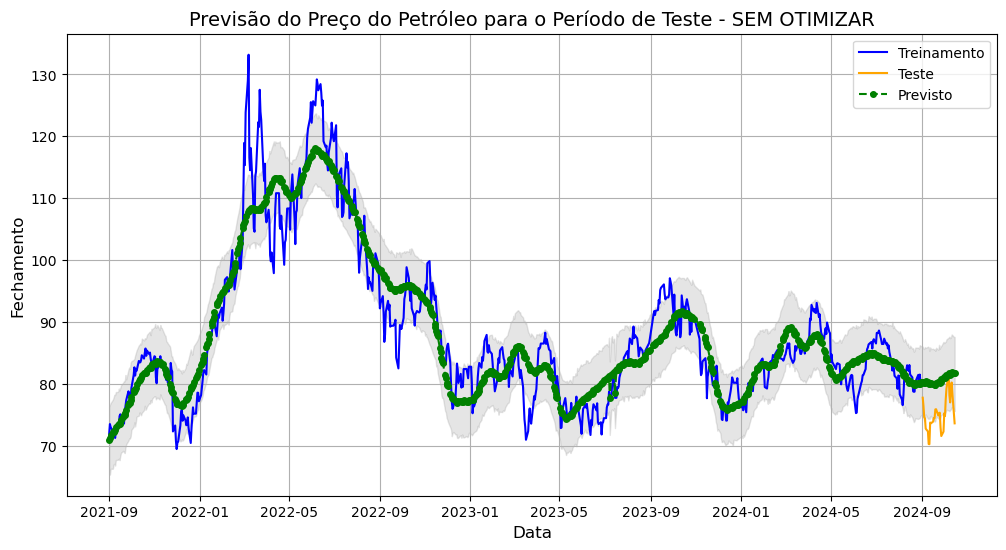

In [10]:
# Plotar as previsões - gráfico completo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['ds'], train['y'], label='Treinamento', color='blue', linewidth=1.5)
ax.plot(test['ds'], test['y'], label='Teste', color='orange', linewidth=1.5)
ax.plot(forecast['ds'], forecast['yhat'], linestyle='--', marker='o', color='green', markersize=4, label='Previsto', linewidth=1.5)
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
ax.set_title('Previsão do Preço do Petróleo para o Período de Teste - SEM OTIMIZAR', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Fechamento', fontsize=12)
ax.legend()
plt.grid(True)
plt.show()

### 1.4 Plotar as Previsões - Gráfico Focado nos Últimos 6 Meses

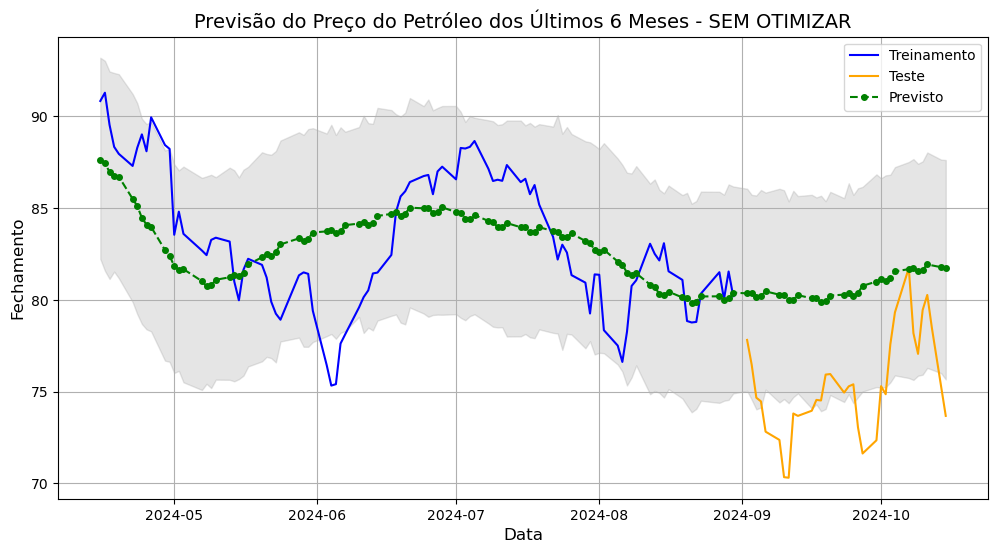

In [11]:
# Plotar as previsões - gráfico focado nos últimos 6 meses
fig, ax = plt.subplots(figsize=(12, 6))

# Filtrar os dados para os últimos 6 meses
start_date = test['ds'].max() - pd.DateOffset(months=6)
train_last_6_months = train[train['ds'] >= start_date]
test_last_6_months = test[test['ds'] >= start_date]
forecast_last_6_months = forecast[forecast['ds'] >= start_date]

ax.plot(train_last_6_months['ds'], train_last_6_months['y'], label='Treinamento', color='blue', linewidth=1.5)
ax.plot(test_last_6_months['ds'], test_last_6_months['y'], label='Teste', color='orange', linewidth=1.5)
ax.plot(forecast_last_6_months['ds'], forecast_last_6_months['yhat'], linestyle='--', marker='o', color='green', markersize=4, label='Previsto', linewidth=1.5)
ax.fill_between(forecast_last_6_months['ds'], forecast_last_6_months['yhat_lower'], forecast_last_6_months['yhat_upper'], color='gray', alpha=0.2)
ax.set_title('Previsão do Preço do Petróleo dos Últimos 6 Meses - SEM OTIMIZAR', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Fechamento', fontsize=12)
ax.legend()
plt.grid(True)
plt.show()

### 1.5 Comparação de Valores Reais e Previstos para o Período de Teste


Comparação de valores reais e previstos para o período de teste antes da otimização:



,y,yhat,erro_proporcional
ds,,,
2024-10-01,75.30,81.131447,-7.744286
2024-10-02,74.86,81.006279,-8.210365
2024-10-03,77.57,81.166588,-4.636571
2024-10-04,79.32,81.548672,-2.809722
2024-10-07,81.74,81.678736,0.074949
2024-10-08,78.19,81.752025,-4.555602
2024-10-09,77.06,81.556252,-5.834742
2024-10-10,79.45,81.636882,-2.752526
2024-10-11,80.27,81.932247,-2.070819


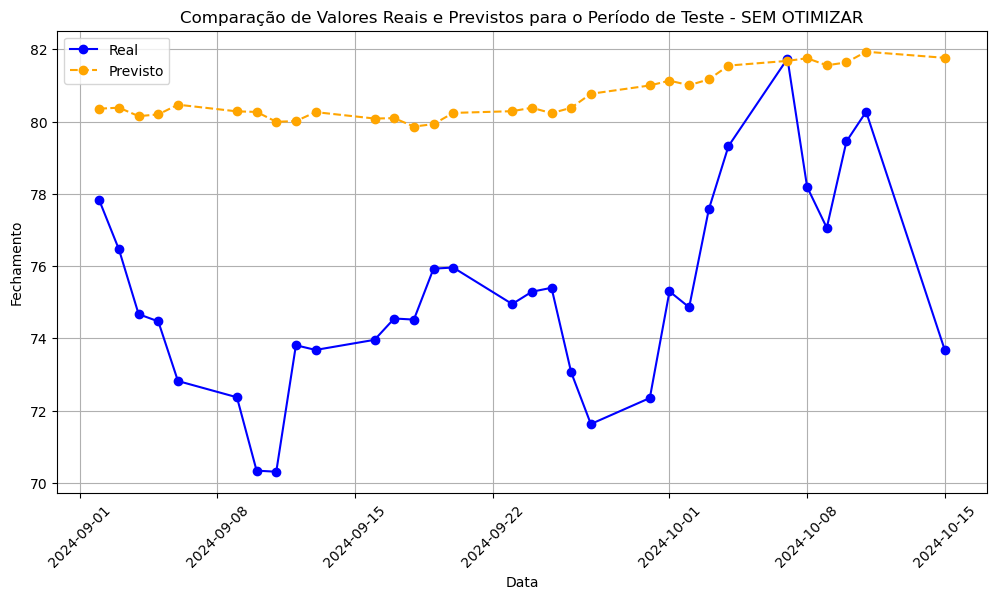

In [12]:
# Comparação de valores reais e previstos para o período de teste antes da otimização
comparison_before = test.set_index('ds').join(forecast[['ds', 'yhat']].set_index('ds'))
comparison_before = comparison_before.dropna()

# Adicionar coluna com a proporção do erro antes da otimização
comparison_before['erro_proporcional'] = ((comparison_before['y'] - comparison_before['yhat']) / comparison_before['y']) * 100

# Exibir a comparação de valores reais e previstos antes da otimização
print("\nComparação de valores reais e previstos para o período de teste antes da otimização:\n")
display(comparison_before.tail(10))

# Plotar gráfico de comparação
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando valores reais e previstos
ax1.plot(comparison_before.index, comparison_before['y'], label='Real', color='blue', marker='o')
ax1.plot(comparison_before.index, comparison_before['yhat'], label='Previsto', color='orange', linestyle='--', marker='o')
ax1.set_title('Comparação de Valores Reais e Previstos para o Período de Teste - SEM OTIMIZAR')
ax1.set_xlabel('Data')
ax1.set_ylabel('Fechamento', color='black')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

plt.show()

### 1.6 Calcular Métricas de Avaliação

In [13]:
# Calcular métricas de avaliação antes da otimização dos hiperparâmetros
mae_before, rmse_before, mape_before, smape_before, r2_before, wmape_before = calculate_metrics(comparison_before['y'], comparison_before['yhat'])

# Exibir resultados antes da otimização dos hiperparâmetros
print(f'Métricas para o período de teste ANTES otimização de hiperparâmetros:')
print(f'MAE: {mae_before}')
print(f'RMSE: {rmse_before}')
print(f'MAPE: {mape_before}%')
print(f'sMAPE: {smape_before}%')
print(f'R-Squared: {r2_before}')
print(f'WMAPE: {wmape_before}%')

Métricas para o período de teste ANTES otimização de hiperparâmetros:
MAE: 5.455796379237471
RMSE: 5.946050888465393
MAPE: 7.372320133599332%
sMAPE: 7.058721783694256%
R-Squared: 0.3725929189934846
WMAPE: 7.253212671654036%


### 1.7 Treinar o Modelo Prophet para Previsões Futuras do Preço do Petróleo

In [14]:
# Treinar o modelo Prophet com feriados
model = Prophet()
model.fit(df_Preco_Petroleo)

# Fazer previsões futuras para os próximos 5 dias úteis
future_periods = 5
future_5_days = model.make_future_dataframe(periods=future_periods, freq='B')  # 'B' para dias úteis
forecast = model.predict(future_5_days)

23:34:53 - cmdstanpy - INFO - Chain [1] start processing
23:34:53 - cmdstanpy - INFO - Chain [1] done processing


### 1.8 Plotar os Valores Históricos e as Previsões Futuras

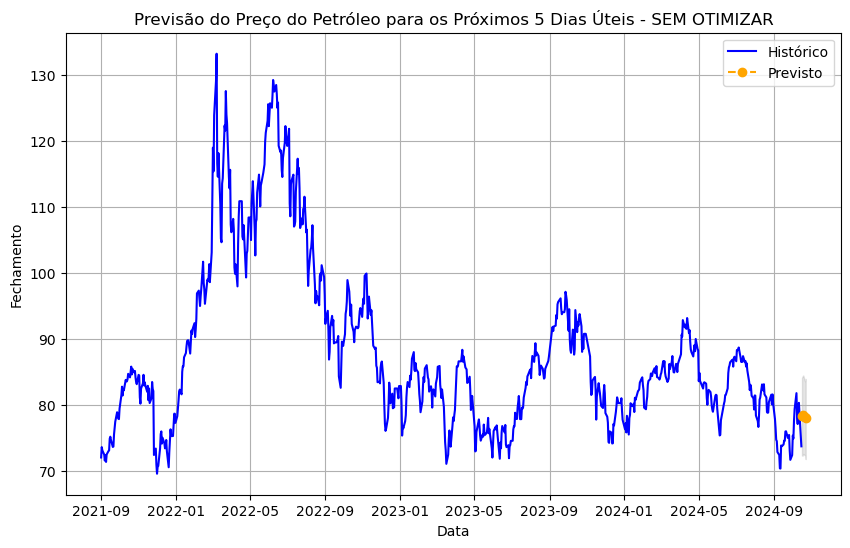

,ds,yhat,yhat_lower,yhat_upper
795,2024-10-16,78.205754,72.289485,84.071310
796,2024-10-17,78.230980,72.270433,84.272015
797,2024-10-18,78.437041,72.517081,84.420825
798,2024-10-21,78.100179,72.300851,83.554079
799,2024-10-22,77.980191,71.745665,83.894269


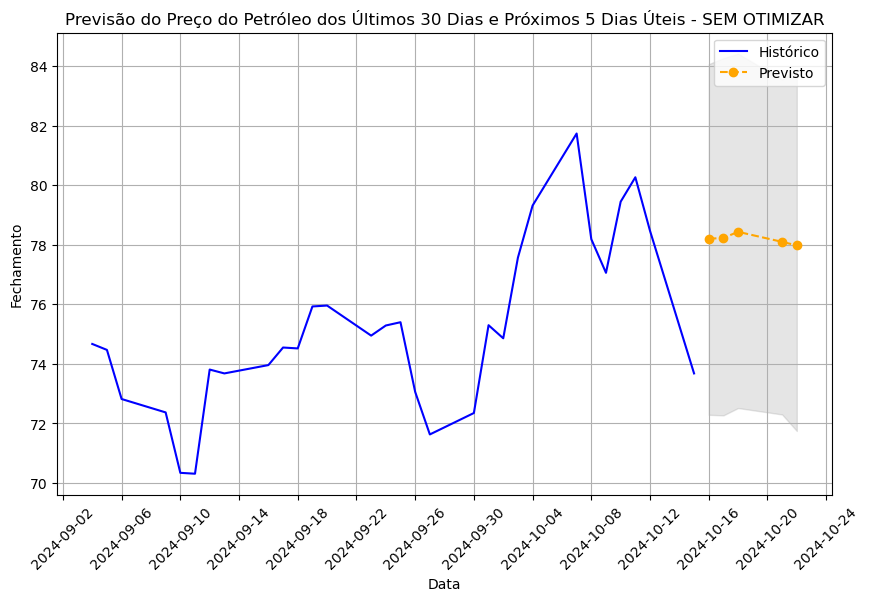

In [15]:
# Plotar os valores históricos e as previsões futuras (gráfico completo)
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar os valores históricos
ax.plot(df_Preco_Petroleo['ds'], df_Preco_Petroleo['y'], label='Histórico', color='blue')

# Plotar apenas os valores futuros previstos
future_forecast = forecast.tail(future_periods)
ax.plot(future_forecast['ds'], future_forecast['yhat'], linestyle='--', marker='o', color='orange', label='Previsto')
ax.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2)

ax.set_title('Previsão do Preço do Petróleo para os Próximos 5 Dias Úteis - SEM OTIMIZAR')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')
ax.legend()
plt.grid(True)
plt.show()

# Exibir as previsões para os próximos 5 dias úteis
forecast_future = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
display(forecast_future)

# Plotar um gráfico para um período mais curto (últimos 30 dias + 5 dias futuros)
fig, ax = plt.subplots(figsize=(10, 6))

# Selecionar os últimos 30 dias de histórico
last_30_days = df_Preco_Petroleo.tail(30)

# Plotar os últimos 30 dias de valores históricos
ax.plot(last_30_days['ds'], last_30_days['y'], label='Histórico', color='blue')

# Plotar os valores futuros previstos
ax.plot(future_forecast['ds'], future_forecast['yhat'], linestyle='--', marker='o', color='orange', label='Previsto')
ax.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2)

ax.set_title('Previsão do Preço do Petróleo dos Últimos 30 Dias e Próximos 5 Dias Úteis - SEM OTIMIZAR')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')
ax.legend()
plt.grid(True)

# Ajustar rotação dos rótulos do eixo x e aumentar a quantidade de rótulos
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

## 2 - OTIMIZAR HIPERPARÂMETROS

### 2.1 Função para Otimizar os Hiperparâmetros das Métricas WMAPE e R²

In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_absolute_error
import json

# Função para calcular WMAPE
def calculate_wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

# Função para otimizar os hiperparâmetros para R² e WMAPE
def optimize_prophet_hyperparameters(train, test, param_grid, weight_r2=0.5, weight_wmape=0.5):
    best_params = None
    best_score = float('-inf')
    
    for params in ParameterGrid(param_grid):
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale']#,
#             holidays=holidays_df
        )
        model.fit(train)
        
        future = model.make_future_dataframe(periods=len(test), freq='B')
        forecast = model.predict(future)
        
        # Comparação de valores reais e previstos para o período de teste
        comparison = test.set_index('ds').join(forecast[['ds', 'yhat']].set_index('ds'))
        comparison = comparison.dropna()
               
        # Calcular R-Squared e WMAPE
        r2 = r2_score(comparison['y'], comparison['yhat'])
        wmape = calculate_wmape(comparison['y'], comparison['yhat'])
        
        # Combinação das métricas com pesos
        combined_score = weight_r2 * r2 - weight_wmape * wmape
        
        if combined_score > best_score:
            best_score = combined_score
            best_params = params
            
    return best_params, best_score

# Definindo a grid de hiperparâmetros
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Otimizar os hiperparâmetros
best_params, best_score = optimize_prophet_hyperparameters(train, test, param_grid, weight_r2=0.8, weight_wmape=0.2)

# # Exibir os melhores hiperparâmetros encontrados
# print(f'Melhores Hiperparâmetros: {best_params}')
# print(f'Melhor Score (Combinação de R² e WMAPE): {best_score}')

# Salvar os melhores hiperparâmetros
with open("melhores_hiperparametros.json", "w") as file:
    json.dump(best_params, file, indent=4)

print(f"Melhores hiperparâmetros salvos em 'melhores_hiperparametros.json': {best_params}")
print(f"Melhor Score (Combinação de R² e WMAPE): {best_score}")


23:34:54 - cmdstanpy - INFO - Chain [1] start processing
23:34:55 - cmdstanpy - INFO - Chain [1] done processing
23:34:55 - cmdstanpy - INFO - Chain [1] start processing
23:34:55 - cmdstanpy - INFO - Chain [1] done processing
23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing
23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing
23:34:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1]

Melhores hiperparâmetros salvos em 'melhores_hiperparametros.json': {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}
Melhor Score (Combinação de R² e WMAPE): -0.15859838559562373


### 2.2 Treinar o Modelo Prophet com os Melhores Hiperparâmetros para o Período de TESTE

In [17]:
# Treinar o modelo Prophet com os melhores hiperparâmetros
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
model.fit(train)

# Fazer previsões futuras para o período de teste
future_teste_hiper = model.make_future_dataframe(periods=len(test), freq='B')
forecast = model.predict(future_teste_hiper)

23:35:10 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing


### 2.3 Plotar as Previsões para o Período de Teste - Melhores Hiperparâmetros

,ds,yhat,yhat_lower,yhat_upper
795,2024-10-16,78.205754,72.289485,84.071310
796,2024-10-17,78.230980,72.270433,84.272015
797,2024-10-18,78.437041,72.517081,84.420825
798,2024-10-21,78.100179,72.300851,83.554079
799,2024-10-22,77.980191,71.745665,83.894269


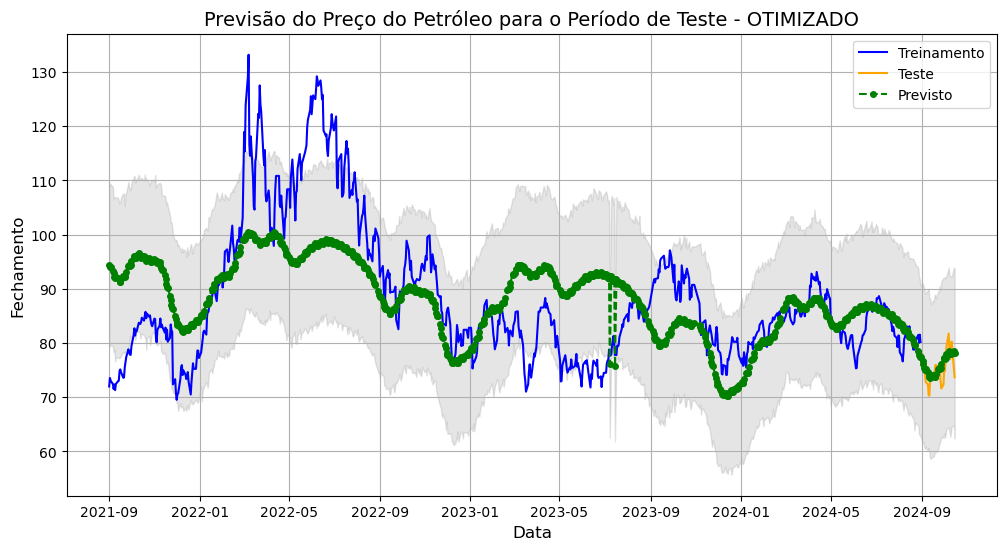

In [18]:
# Exibir as previsões para os próximos 5 dias úteis
forecast_future = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
display(forecast_future)

# Plotar as previsões - gráfico completo
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train['ds'], train['y'], label='Treinamento', color='blue', linewidth=1.5)
ax.plot(test['ds'], test['y'], label='Teste', color='orange', linewidth=1.5)
ax.plot(forecast['ds'], forecast['yhat'], linestyle='--', marker='o', color='green', markersize=4, label='Previsto', linewidth=1.5)

ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

ax.set_title('Previsão do Preço do Petróleo para o Período de Teste - OTIMIZADO', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Fechamento', fontsize=12)
ax.legend()
plt.grid(True)

plt.show()

### 2.4 Plotar as Previsões do Período de Teste- Gráfico Focado nos Últimos 6 Meses - Melhores Hiperparâmetros

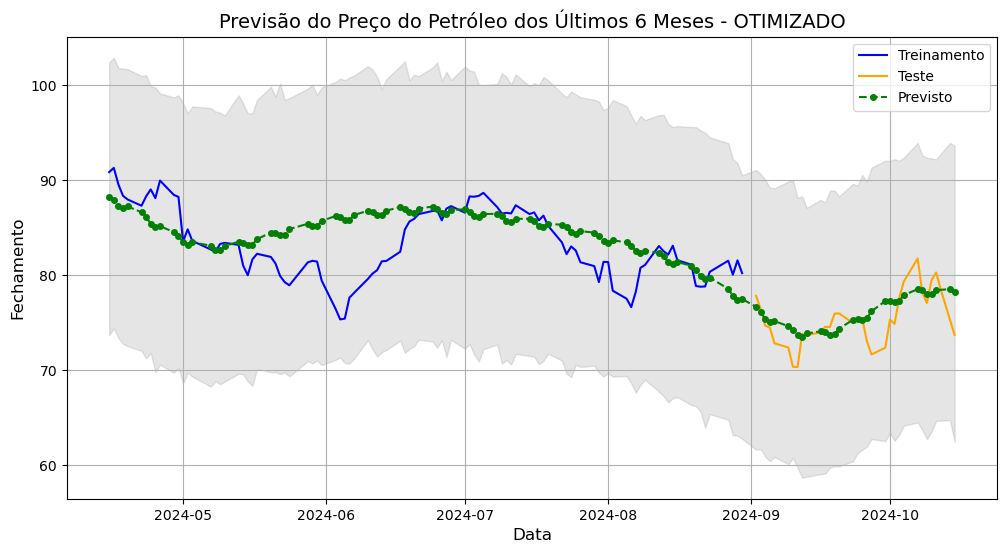

In [19]:
# Plotar as previsões - gráfico focado nos últimos 6 meses
fig, ax = plt.subplots(figsize=(12, 6))

# Filtrar os dados para os últimos 6 meses
start_date = test['ds'].max() - pd.DateOffset(months=6)
train_last_6_months = train[train['ds'] >= start_date]
test_last_6_months = test[test['ds'] >= start_date]
forecast_last_6_months = forecast[forecast['ds'] >= start_date]

ax.plot(train_last_6_months['ds'], train_last_6_months['y'], label='Treinamento', color='blue', linewidth=1.5)
ax.plot(test_last_6_months['ds'], test_last_6_months['y'], label='Teste', color='orange', linewidth=1.5)
ax.plot(forecast_last_6_months['ds'], forecast_last_6_months['yhat'], linestyle='--', marker='o', color='green', markersize=4, label='Previsto', linewidth=1.5)
ax.fill_between(forecast_last_6_months['ds'], forecast_last_6_months['yhat_lower'], forecast_last_6_months['yhat_upper'], color='gray', alpha=0.2)
ax.set_title('Previsão do Preço do Petróleo dos Últimos 6 Meses - OTIMIZADO', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Fechamento', fontsize=12)
ax.legend()
plt.grid(True)
plt.show()

 ### 2.5 Comparação de Valores Reais e Previstos para o Período de TESTE - Melhores Hiperparâmetros


Comparação de valores reais e previstos para o período de teste depois da otimização:



,y,yhat,erro_proporcional
ds,,,
2024-09-02,77.82,76.661627,1.488529
2024-09-03,76.46,76.127402,0.434996
2024-09-04,74.67,75.393699,-0.969196
2024-09-05,74.47,75.012399,-0.728345
2024-09-06,72.82,75.143069,-3.190152
2024-09-09,72.37,74.625166,-3.116161
2024-09-10,70.34,74.241922,-5.547231
2024-09-11,70.31,73.683151,-4.797542
2024-09-12,73.81,73.499099,0.421218


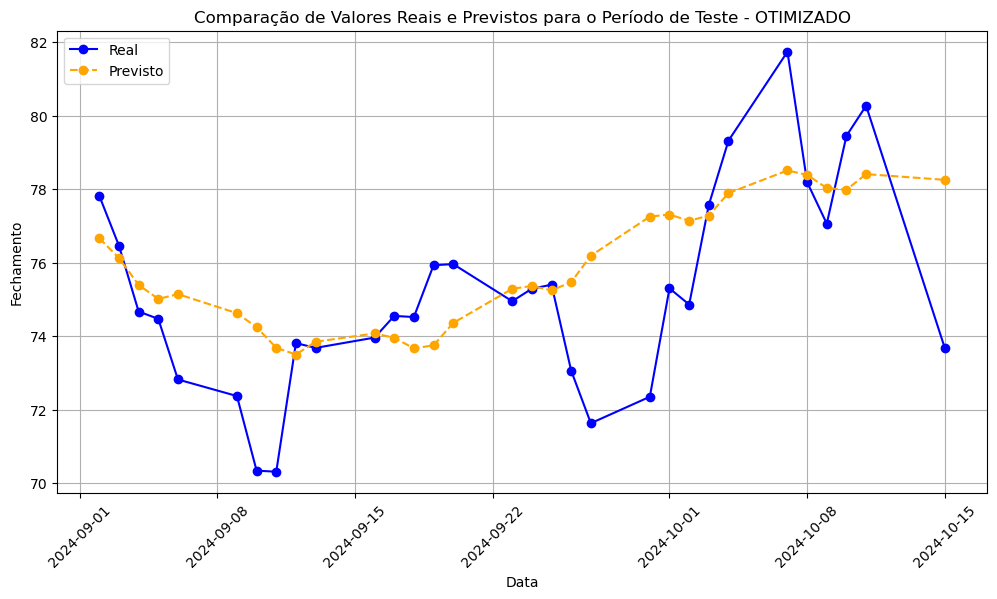

In [20]:
# Comparação de valores reais e previstos para o período de teste depois da otimização
comparison_after = test.set_index('ds').join(forecast[['ds', 'yhat']].set_index('ds'))
comparison_after = comparison_after.dropna()

# Adicionar coluna com a proporção do erro depois da otimização
comparison_after['erro_proporcional'] = ((comparison_after['y'] - comparison_after['yhat']) / comparison_after['y']) * 100

# Exibir a comparação de valores reais e previstos depois da otimização
print("\nComparação de valores reais e previstos para o período de teste depois da otimização:\n")
display(comparison_after)

# Plotar gráfico de comparação
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando valores reais e previstos
ax1.plot(comparison_after.index, comparison_after['y'], label='Real', color='blue', marker='o')
ax1.plot(comparison_after.index, comparison_after['yhat'], label='Previsto', color='orange', linestyle='--', marker='o')
ax1.set_title('Comparação de Valores Reais e Previstos para o Período de Teste - OTIMIZADO')
ax1.set_xlabel('Data')
ax1.set_ylabel('Fechamento', color='black')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

plt.show()

### 2.6 Calcular Métricas de Avaliação - Melhores Hiperparâmetros

In [21]:
# Calcular métricas de avaliação após a otimização dos hiperparâmetros
mae_after, rmse_after, mape_after, smape_after, r2_after, wmape_after = calculate_metrics(comparison_after['y'], comparison_after['yhat'])

# Exibir resultados após a otimização dos hiperparâmetros
print(f'Métricas para o período de teste APÓS otimização de hiperparâmetros:')
print(f'MAE: {mae_after}')
print(f'RMSE: {rmse_after}')
print(f'MAPE: {mape_after}%')
print(f'sMAPE: {smape_after}%')
print(f'R-Squared: {r2_after}')
print(f'WMAPE: {wmape_after}%')

Métricas para o período de teste APÓS otimização de hiperparâmetros:
MAE: 1.6507178197186505
RMSE: 2.1846571296129564
MAPE: 2.2228393810897233%
sMAPE: 2.194195552806662%
R-Squared: 0.40896139814036536
WMAPE: 2.1945480687059375%


### 2.7 Treinar o Modelo Prophet para Previsões Futuras de Fechamento Ibovespa - Melhores Hiperparâmetros

In [22]:
# Treinar o modelo Prophet
model = Prophet()
model.fit(df_Preco_Petroleo)

# Fazer previsões futuras para os próximos 5 dias úteis
future_periods = 5
future = model.make_future_dataframe(periods=future_periods, freq='B')  # 'B' para dias úteis
forecast = model.predict(future)

23:35:11 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing


### 2.8 Plotar os Valores Históricos e as Previsões Futuras - Melhores Hiperparâmetros

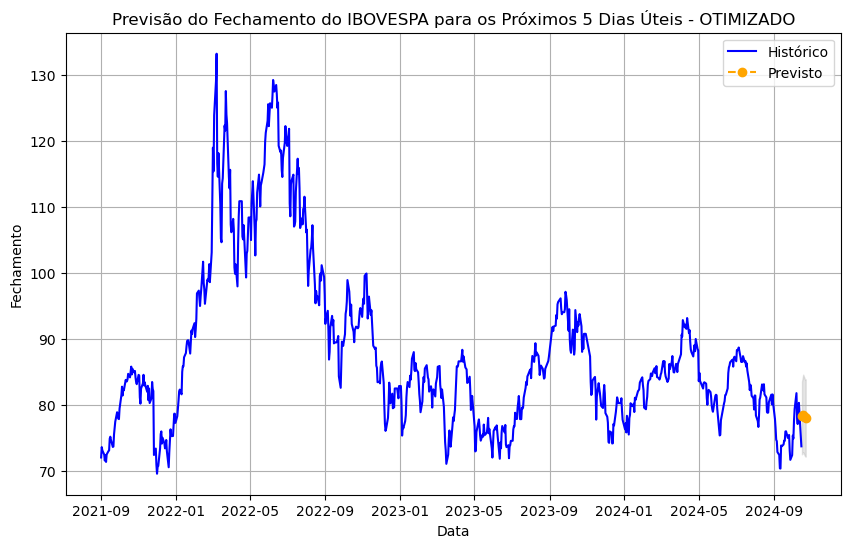

,ds,yhat,yhat_lower,yhat_upper
795,2024-10-16,78.205754,72.472460,83.477521
796,2024-10-17,78.230980,72.689707,84.010087
797,2024-10-18,78.437041,72.800987,84.550446
798,2024-10-21,78.100179,72.175046,83.809193
799,2024-10-22,77.980191,72.120603,83.836504


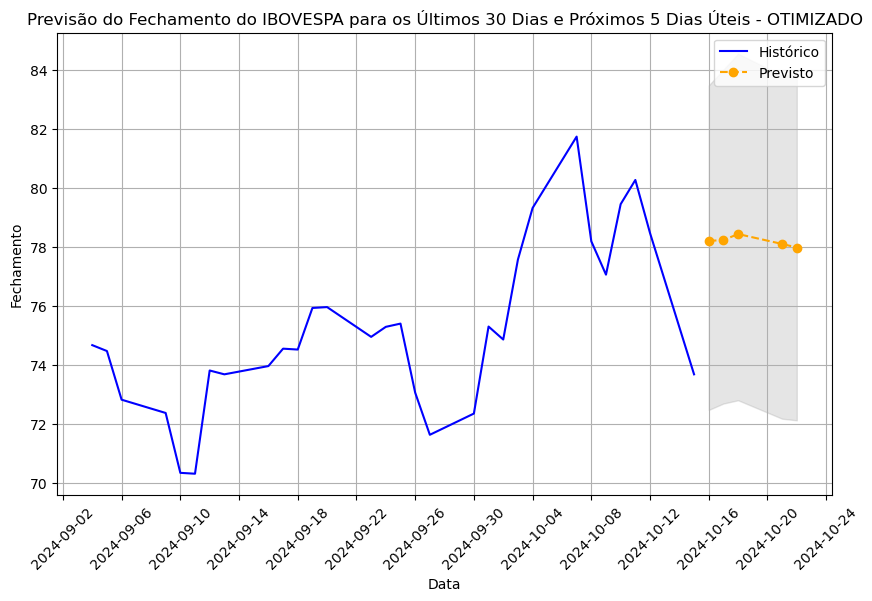

In [23]:
# Plotar os valores históricos e as previsões futuras (gráfico completo)
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar os valores históricos
ax.plot(df_Preco_Petroleo['ds'], df_Preco_Petroleo['y'], label='Histórico', color='blue')

# Plotar apenas os valores futuros previstos
future_forecast = forecast.tail(future_periods)
ax.plot(future_forecast['ds'], future_forecast['yhat'], linestyle='--', marker='o', color='orange', label='Previsto')
ax.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2)

ax.set_title('Previsão do Fechamento do IBOVESPA para os Próximos 5 Dias Úteis - OTIMIZADO')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')
ax.legend()
plt.grid(True)
plt.show()

# Exibir as previsões para os próximos 5 dias úteis
forecast_future = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
display(forecast_future)

# Plotar um gráfico para um período mais curto (últimos 30 dias + 5 dias futuros)
fig, ax = plt.subplots(figsize=(10, 6))

# Selecionar os últimos 30 dias de histórico
last_30_days = df_Preco_Petroleo.tail(30)

# Plotar os últimos 30 dias de valores históricos
ax.plot(last_30_days['ds'], last_30_days['y'], label='Histórico', color='blue')

# Plotar os valores futuros previstos
ax.plot(future_forecast['ds'], future_forecast['yhat'], linestyle='--', marker='o', color='orange', label='Previsto')
ax.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2)

ax.set_title('Previsão do Fechamento do IBOVESPA para os Últimos 30 Dias e Próximos 5 Dias Úteis - OTIMIZADO')
ax.set_xlabel('Data')
ax.set_ylabel('Fechamento')
ax.legend()
plt.grid(True)

# Ajustar rotação dos rótulos do eixo x e aumentar a quantidade de rótulos
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()


# 3 - Comparaçõres Métricas - Antes e Depois - Hiperparâmetros

### 3.1 Comparar Métricas de Avaliação Antes e Depois da Otimização dos Hiperparâmetros


Comparação de métricas antes e depois da otimização de hiperparâmetros:



,MAE,RMSE,MAPE (%),sMAPE (%),R-Squared,WMAPE (%)
Before Optimization,5.455796,5.946051,7.372320,7.058722,0.372593,7.253213
After Optimization,1.650718,2.184657,2.222839,2.194196,0.408961,2.194548


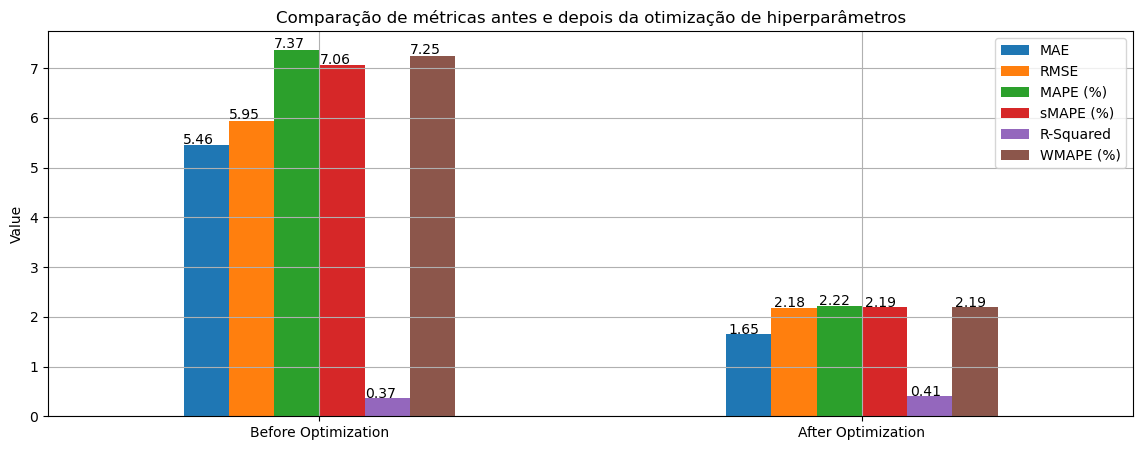

In [24]:
# Comparar métricas de avaliação antes e depois da otimização dos hiperparâmetros
metrics_comparison = {
    'MAE': [mae_before, mae_after],
    'RMSE': [rmse_before, rmse_after],
    'MAPE (%)': [mape_before, mape_after],
    'sMAPE (%)': [smape_before, smape_after],
    'R-Squared': [r2_before, r2_after],
    'WMAPE (%)': [wmape_before, wmape_after]
}

metrics_comparison_df = pd.DataFrame(metrics_comparison, index=['Before Optimization', 'After Optimization'])

# Exibir comparação das métricas
print("\nComparação de métricas antes e depois da otimização de hiperparâmetros:\n")
display(metrics_comparison_df)

# Plotar comparação das métricas em um gráfico de barras
fig, ax = plt.subplots(figsize=(14, 5))
metrics_comparison_df.plot(kind='bar', ax=ax)
ax.set_title('Comparação de métricas antes e depois da otimização de hiperparâmetros')
ax.set_ylabel('Value')
ax.grid(True)

# Adicionar os valores de rótulos nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

# Ajustar rotação dos rótulos do eixo x
plt.xticks(rotation=0)
plt.show()


## 3.2 Plotar Gráfico Comparativo dos Erros Proporcionais Antes e Depois da Otimização

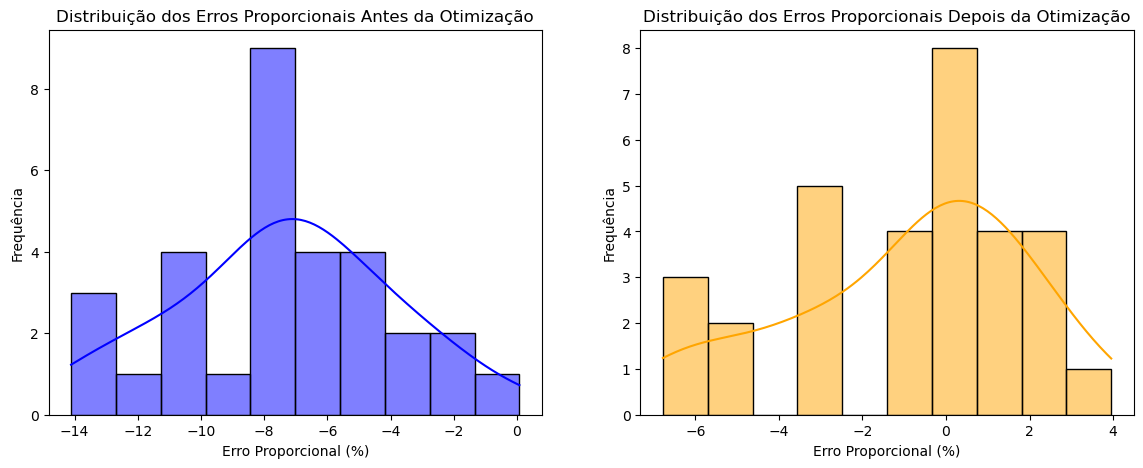

In [25]:
# Plotar gráfico comparativo dos erros proporcionais antes e depois da otimização
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico antes da otimização
sns.histplot(comparison_before['erro_proporcional'], bins=10, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Distribuição dos Erros Proporcionais Antes da Otimização')
ax[0].set_xlabel('Erro Proporcional (%)')
ax[0].set_ylabel('Frequência')

# Gráfico depois da otimização
sns.histplot(comparison_after['erro_proporcional'], bins=10, kde=True, ax=ax[1], color='orange')
ax[1].set_title('Distribuição dos Erros Proporcionais Depois da Otimização')
ax[1].set_xlabel('Erro Proporcional (%)')
ax[1].set_ylabel('Frequência')

plt.show()